# Deterministic Global Optimization
Prepared by: Yohannes Mariam (ymariam@nd.edu, [ymariam1](https://github.com/ymariam1), 2024) and Oliver Harris (oharris2@nd.edu, [@OliverHarris47](https://github.com/OliverHarris47), 2024)

In [ ]:
# This code cell installs packages on Colab

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

--2024-12-13 14:25:42--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-12-13 14:25:42 (68.6 MB/s) - ‘helper.py’ saved [6493/6493]

Installing idaes via pip...
idaes was successfully installed
idaes, version 2.7.0


Running idaes get-extensions to install Ipopt, k_aug, and more...
Checking solver versions:
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)



[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)



Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimiz

In [ ]:
import pandas as pd
import pyomo.environ as pyo

## Learning Objectives
*   Review syntax and components in Pyomo
*   Become acquanted with global solvers in Pyomo
*   Learn to use the GAMS file writer and access the NEOS server
*   Gain an introduction into Deterministic Global Optimization Algorithms
*   Uncover neuance in nonlinear, nonconvex programming problems



## Introduction
Global optimization (GO) focuses on finding the global minimum or maximum of an objective function over a feasible domain, often characterized by numerous local optima. Unlike local optimization, GO addresses challenges in problems where local minima do not also guarantee global optimality. Recent advancements in algorithms, complexity analysis, and computational tools have driven significant growth in the field. Applications span diverse areas, including molecular conformation, distance geometry, packing, and trajectory planning.

Complexity analysis is critical in GO, as it evaluates the inherent difficulty of optimization problems. This assessment helps determine whether exact solutions are feasible or if approximate methods must be employed. Heuristics, such as metaheuristic frameworks and function modeling, are commonly used to navigate the search space efficiently, especially when function evaluations are computationally expensive. Branch-and-bound techniques provide systematic frameworks for exact solutions by iteratively dividing the problem space and calculating bounds to eliminate suboptimal regions. Lower bound computation, often via convex relaxations, is integral to both exact (deterministic) and heuristic methods, offering guarantees on the quality of solutions and improving algorithmic

This notebook will focus on deterministic approaches to GO problems, particularly the 'Spatial Branch and Bound' algorithm and the BARON and Couenne solvers which take this approach. This method is valid under certain qualifying assumptions that are revealed in the complexity analysis of a GO problem. Additional reading for complexity analysis, heuristics, lower bound computation, and branch and bound methods can be found at:

https://www.google.com/url?q=https%3A%2F%2Foptimization.cbe.cornell.edu%2Findex.php%3Ftitle%3DSpatial_branch_and_bound_method


https://epubs.siam.org/doi/book/10.1137/1.9781611972672

## Global Optimization
* Given a function $f$ how do we ensure that the optima we find is a global optima?
* Do we have a method to solve optimization problems with nonlinear objects or constraints with poor initialization?

**Review**

* Let $\mathcal{F}$ be defined as the feasible region $\mathcal{F} = \{ x\mid g(x)\leq 0, h(x) = 0 \}$

*  A point $x^*$ is a ***global minimizer*** if $f(x^*) \leq f(x)$ for all $x \in \mathcal{F}$


*  **Theorem 4.3** If $f(x) $ is convex and $ \mathcal{F} $ is convex, then every local minimum in $ \mathcal{F} $ is a global minimum. If $ f(x) $ is strictly convex in $ \mathcal{F} $, then a local minimum is the unique global minimum.

(Biegler, 2010, Chapter 4)

### Spatial Branch and Bound Algorithm

**Main Idea:** Spatial branch-and-bound is a divide-and-conquer technique for global optimization. It systematically partitions a problems feasible space into sub-spaces, computes bounds for solutions, and prunes infeasible regions.

Algorithm:


![](../../media/contrib/SBB_Algorithm.png)

Figure source: https://optimization.cbe.cornell.edu/index.php?title=Spatial_branch_and_bound_method

Proof of convergence:

A branch-and-bound method that uses exact selection rules will eventually converge, because at each iteration it discards regions of the solution space that cannot contain a better solution than the current best one. The remaining “qualified” subregions always include the global optimum, ensuring that—given infinite time—the method will find it.

*It is noted that the spacial branch and bound algorithm does not guarantee convergence in a finite number of steps*

![](../../media/contrib/SBB_Convergence.png)

Figure source: https://optimization.cbe.cornell.edu/index.php?title=Spatial_branch_and_bound_method

Example:

![](../../media/contrib/SBB_Example_1.png)

Figure source: https://optimization.cbe.cornell.edu/index.php?title=Spatial_branch_and_bound_method

## Circle Packing Example Revisited

What is the smallest rectangle you can use to enclose three given circles? Reference: Example 4.4 in Biegler (2010).

![picture](https://raw.githubusercontent.com/ndcbe/optimization/main/media/pack1.png)

### Propose an Optimization Model

The following optimization model is given in Biegler (2010):

$$
\begin{align}
\text{min} \quad & 2(A + B) \\
\text{s.t.} \quad & A \geq 0, \quad B \geq 0, \\
& x_1, y_1, \geq R_1, \quad x_1 \leq B - R_1, \quad y_1 \leq A - R_1, \\
& x_2, y_2, \geq R_2, \quad x_2 \leq B - R_2, \quad y_2 \leq A - R_2, \\
& x_3, y_3, \geq R_3, \quad x_3 \leq B - R_3, \quad y_3 \leq A - R_3, \\
& (x_1 - x_2)^2 + (y_1 - y_2)^2 \geq (R_1 + R_2)^2, \\
& (x_1 - x_3)^2 + (y_1 - y_3)^2 \geq (R_1 + R_3)^2, \\
& (x_2 - x_3)^2 + (y_2 - y_3)^2 \geq (R_2 + R_3)^2,
\end{align}
$$

### Implement in Pyomo

First, we will define functions to create and intialize the model.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def create_circle_model(circle_radii):
    ''' Create circle optimization model in Pyomo

    Arguments:
        circle_radii: dictionary with keys=circle name and value=radius (float)

    Returns:
        model: Pyomo model
    '''

    # Number of circles to consider
    n = len(circle_radii)

    # Create a concrete Pyomo model.
    model = pyo.ConcreteModel()

    # Initialize index for circles
    model.CIRCLES = pyo.Set(initialize = circle_radii.keys())

    # Create parameter
    model.R = pyo.Param(model.CIRCLES, domain=pyo.PositiveReals, initialize=circle_radii)

    # Create variables for box
    model.a = pyo.Var(domain=pyo.PositiveReals)
    model.b = pyo.Var(domain=pyo.PositiveReals)

    # Set objective
    model.obj = pyo.Objective(expr=2*(model.a + model.b), sense = pyo.minimize)

    # Create variables for circle centers
    model.x = pyo.Var(model.CIRCLES, domain=pyo.PositiveReals)
    model.y = pyo.Var(model.CIRCLES, domain=pyo.PositiveReals)

    # "In the box" constraints
    def left_x(m,c):
        return m.x[c] >= model.R[c]
    model.left_x_con = pyo.Constraint(model.CIRCLES, rule=left_x)

    def left_y(m,c):
        return m.y[c] >= model.R[c]
    model.left_y_con = pyo.Constraint(model.CIRCLES, rule=left_y)

    def right_x(m,c):
        return m.x[c] <= m.b - model.R[c]
    model.right_x_con = pyo.Constraint(model.CIRCLES, rule=right_x)

    def right_y(m,c):
        return m.y[c] <= m.a - model.R[c]
    model.right_y_con = pyo.Constraint(model.CIRCLES, rule=right_y)

    # No overlap constraints
    def no_overlap(m,c1,c2):
        if c1 < c2:
            return (m.x[c1] - m.x[c2])**2 + (m.y[c1] - m.y[c2])**2 >= (model.R[c1] + model.R[c2])**2
        else:
            return pyo.Constraint.Skip
    model.no_overlap_con = pyo.Constraint(model.CIRCLES, model.CIRCLES, rule=no_overlap)

    return model

def initialize_circle_model(model, a_init=25, b_init=25):
    ''' Initialize the x and y coordinates using uniform distribution

    Arguments:
        a_init: initial value for a (default=25)
        b_init: initial value for b (default=25)

    Returns:
        Nothing. But per Pyomo scoping rules, the input argument `model`
        can be modified in this function.

    '''
    # Initialize
    model.a = 25
    model.b = 25

    for i in model.CIRCLES:
        # Adding circle radii ensures the remains in the >0, >0 quadrant
        model.x[i] = random.uniform(0,10) + model.R[i]
        model.y[i] = random.uniform(0,10) + model.R[i]



Next, we will create a dictionary containing the circle names and radii values.

In [ ]:
# Create dictionary with circle data
circle_data = {'A':10.0, 'B':5.0, 'C':3.0}
circle_data

{'A': 10.0, 'B': 5.0, 'C': 3.0}

In [ ]:
# Access the keys
circle_data.keys()

dict_keys(['A', 'B', 'C'])

Now let's create the model.

In [ ]:
# Create model
model = create_circle_model(circle_data)
model.pprint()

1 Set Declarations
    CIRCLES : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'C'}

1 Param Declarations
    R : Size=3, Index=CIRCLES, Domain=PositiveReals, Default=None, Mutable=False
        Key : Value
          A :  10.0
          B :   5.0
          C :   3.0

4 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : PositiveReals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : PositiveReals
    x : Size=3, Index=CIRCLES
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          A :     0 :  None :  None : False :  True : PositiveReals
          B :     0 :  None :  None : False :  True : PositiveReals
          C :     0 :  None :  None : False :  True : PositiveReals
    y : Size=

And let's initialize the model.

In [ ]:
# Initialize model
initialize_circle_model(model)
model.pprint()

1 Set Declarations
    CIRCLES : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'C'}

1 Param Declarations
    R : Size=3, Index=CIRCLES, Domain=PositiveReals, Default=None, Mutable=False
        Key : Value
          A :  10.0
          B :   5.0
          C :   3.0

4 Var Declarations
    a : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    25 :  None : False : False : PositiveReals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :    25 :  None : False : False : PositiveReals
    x : Size=3, Index=CIRCLES
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
          A :     0 :  11.00238023004687 :  None : False : False : PositiveReals
          B :     0 : 12.973073338884655 :  None : False : False : PositiveReals
          C :     0 :   3.95238696971243 :

<div class="admonition note">
    <p class="title"><b>Activity</b></p>
 Compare the initial values for <tt>x</tt> and <tt>y</tt> with and without initialization. What is the default initial value in Pyomo?
</div>

### Visualize Initial Point

Next, we'll define a function to plot the solution (or initial point)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_circles(m):
    ''' Plot circles using data in Pyomo model with updated style

    Arguments:
        m: Pyomo concrete model

    Returns:
        Nothing (but makes a figure)

    '''
    # Create figure with specified size and DPI
    fig, ax = plt.subplots(figsize=(4, 6.4), dpi=300)

    # Define padding
    padding = 2  # Minimum padding of 2 units

    # Adjust axes based on box dimensions with padding
    ax.set_xlim(0 - padding, m.b.value + padding)
    ax.set_ylim(0 - padding, m.a.value + padding)
    ax.set_aspect('equal', adjustable='box')

    # Draw box
    box = mpatches.Rectangle((0, 0), width=m.b.value, height=m.a.value,
                             fill=False, edgecolor='blue', linewidth=1)
    ax.add_patch(box)

    # Draw circles (with shading, no outline) and mark centers
    for i in m.CIRCLES:
        circle = mpatches.Circle((m.x[i].value, m.y[i].value), radius=m.R[i],
                                 facecolor='orange', alpha=0.5, linewidth=0)  # No outline
        ax.add_patch(circle)
        ax.scatter(m.x[i].value, m.y[i].value, color='red', s=3 ** 2)  # Marker size is 8

    # Update axis ticks and labels
    ax.tick_params(axis='both', which='major', labelsize=15, direction='in', length=6, width=2)
    ax.tick_params(axis='both', which='minor', labelsize=15, direction='in', length=3, width=1.5)

    # Add grid with adjusted transparency
    #ax.grid(True, linestyle='--', alpha=0.5)

    # Update title
    ax.set_title('Circle Arrangement', fontsize=16, fontweight='bold')

    # Update axis labels
    ax.set_xlabel('B', fontsize=16, fontweight='bold')  # Label for x-axis
    ax.set_ylabel('A', fontsize=16, fontweight='bold')  # Label for y-axis

    # Show plot
    plt.show()



### Solve and Inspect the Solution

In [ ]:
# Specify the solver
solver = pyo.SolverFactory('ipopt')

# Solve the model
results = solver.solve(model, tee = True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Next, we can inspect the solution. Because Pyomo is a Python extension, we can use Pyoth (for loops, etc.) to programmatically inspect the solution.

Name	Value
a 	 29.142135416184768
b 	 19.99999980318952
x[A] 	 9.999999901252018
x[B] 	 14.999999849644137
x[C] 	 4.720751204469878
y[A] 	 19.14213551493193
y[B] 	 4.999999951252107
y[C] 	 5.393841562704629


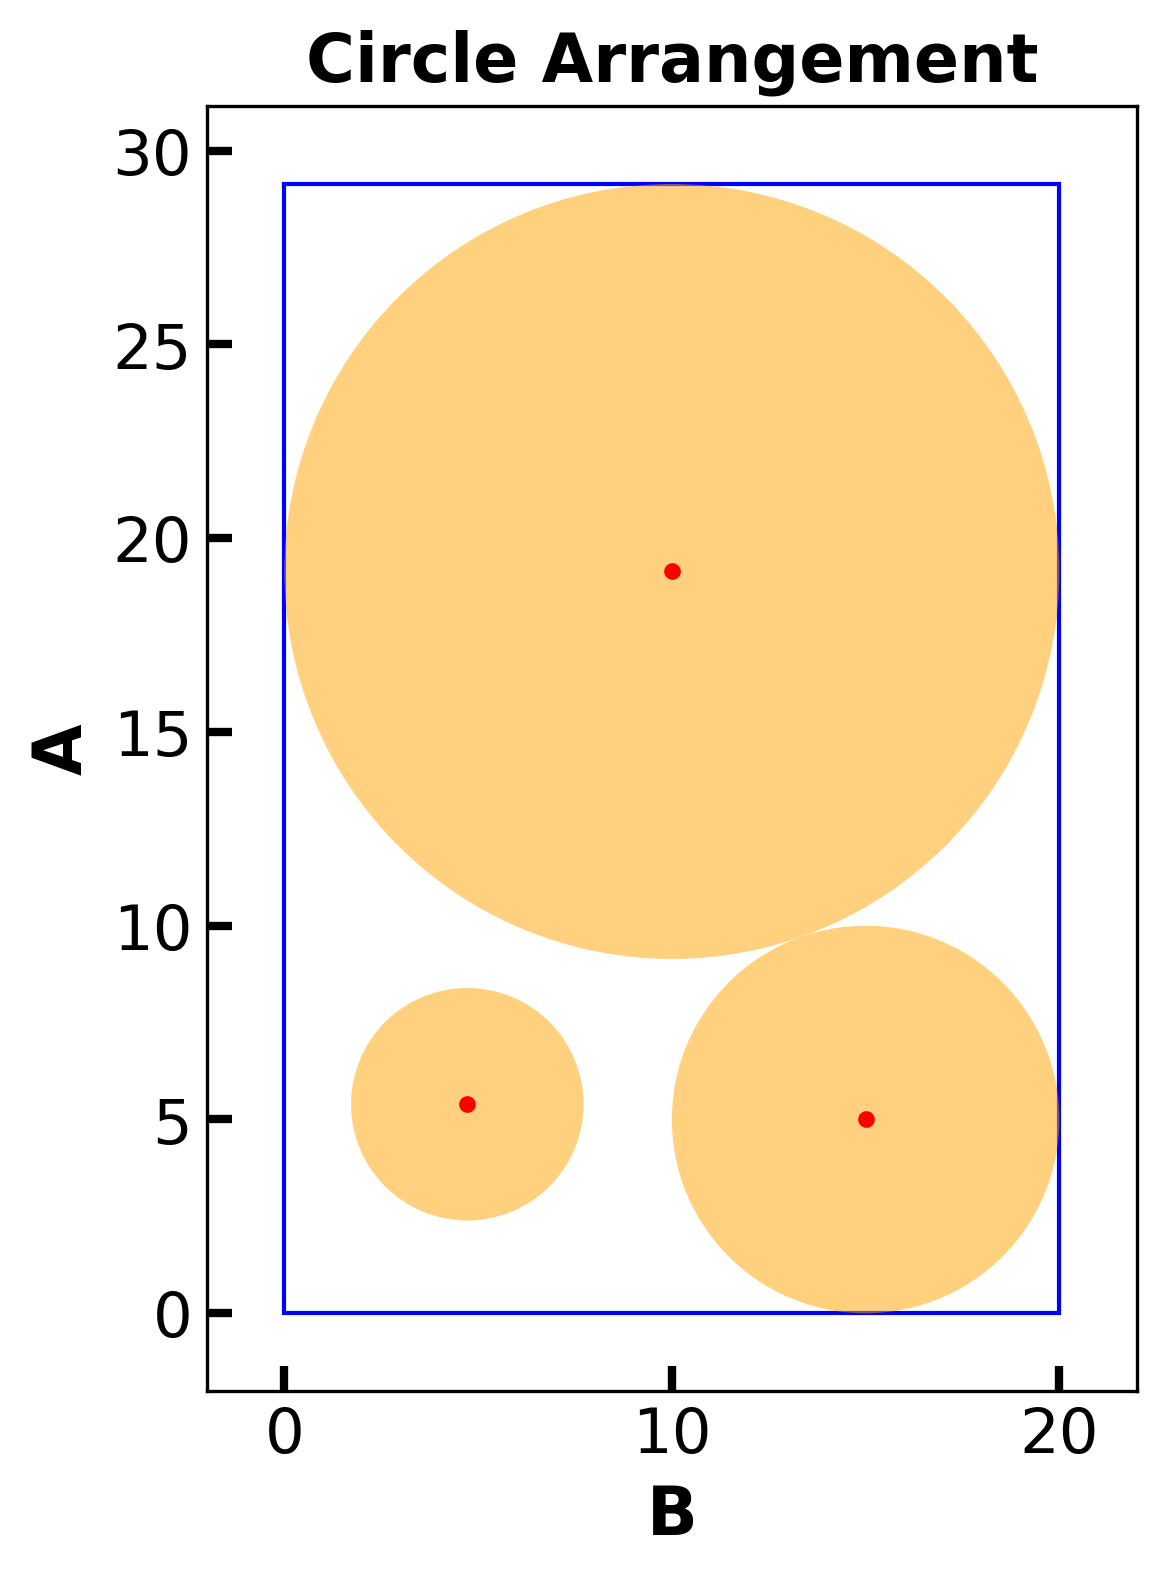

In [ ]:
# Print variable values
print("Name\tValue")
for c in model.component_data_objects(pyo.Var):
    print(c.name,"\t", pyo.value(c))

# Plot solution
plot_circles(model)

In [ ]:
# Print constraints
for c in model.component_data_objects(pyo.Constraint):
    print(c.name,"\t", pyo.value(c.lower),"\t", pyo.value(c.body),"\t", pyo.value(c.upper))

left_x_con[A] 	 10.0 	 9.999999901252018 	 None
left_x_con[B] 	 5.0 	 14.999999849644137 	 None
left_x_con[C] 	 3.0 	 4.720751204469878 	 None
left_y_con[A] 	 10.0 	 19.14213551493193 	 None
left_y_con[B] 	 5.0 	 4.999999951252107 	 None
left_y_con[C] 	 3.0 	 5.393841562704629 	 None
right_x_con[A] 	 None 	 9.806249678945278e-08 	 0.0
right_x_con[B] 	 None 	 4.6454616153823736e-08 	 0.0
right_x_con[C] 	 None 	 -12.279248598719644 	 0.0
right_y_con[A] 	 None 	 9.87471615587765e-08 	 0.0
right_y_con[B] 	 None 	 -19.14213546493266 	 0.0
right_y_con[C] 	 None 	 -20.74829385348014 	 0.0
no_overlap_con[A,B] 	 225.0 	 224.9999977854188 	 None
no_overlap_con[A,C] 	 169.0 	 216.88605339932565 	 None
no_overlap_con[B,C] 	 64.0 	 105.81806392422837 	 None


### Take Away Messages
* Nonlinear programs may be nonconvex. For nonconvex problems, there often existings many local optima that are not also global optima.
* We will learn how to mathematically define convexity and analyze this property.
* Initialization is really important in optimization problems with nonlinear objectives or constraints!
* There are specialize solves for linear programs, quadratic programs, and convex programs. In this class, we will focus on more general algorithms for (non)convex nonlinear programs including the algorithms used by the `ipopt` solver.

## Deterministic global optimization solvers

### Couenne Solver

In [ ]:
# Create model
model = create_circle_model(circle_data)
#model.pprint()

In [ ]:
# Initialize model
initialize_circle_model(model)
# model.pprint()

In [ ]:
# Specify the solver
solver = pyo.SolverFactory('couenne')

# Solve the model
results = solver.solve(model, tee = True)

Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne: 
ANALYSIS TEST: NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 98.28427       21 0.008176
Couenne: new cutoff value 9.8284270824e+01 (0.019852 seconds)
Loaded instance "/tmp/tmpe1rb3m73.pyomo.nl"
Constraints:           15
Variables:              8 (0 integer)
Auxiliaries:           16 (0 integer)

Coin0506I Presolve 40 (0) rows, 21 (-3) columns and 87 (-3) elements
Clp0006I 0  Obj 80 Primal inf 980.53922 (21)
Clp0006I 17  Obj 80
Clp0000I Optimal - objective value 80
Clp0032I Optimal objective 80 - 17 iterations time 0.002, Presolve 0.00
Clp0000I Optimal - objective value 80
Cbc0012I Integer solution of 98.284271 found by Couenne Rounding NLP after 0 iterations and 0 nodes (0.00 seconds)
NLP Heuristic: NLP0014I             2      

Name	Value
a 	 29.142135411880613
b 	 20.0
x[A] 	 10.0
x[B] 	 14.999999850009898
x[C] 	 5.3759828526460005
y[A] 	 19.142135511875615
y[B] 	 5.0
y[C] 	 6.479397184813547


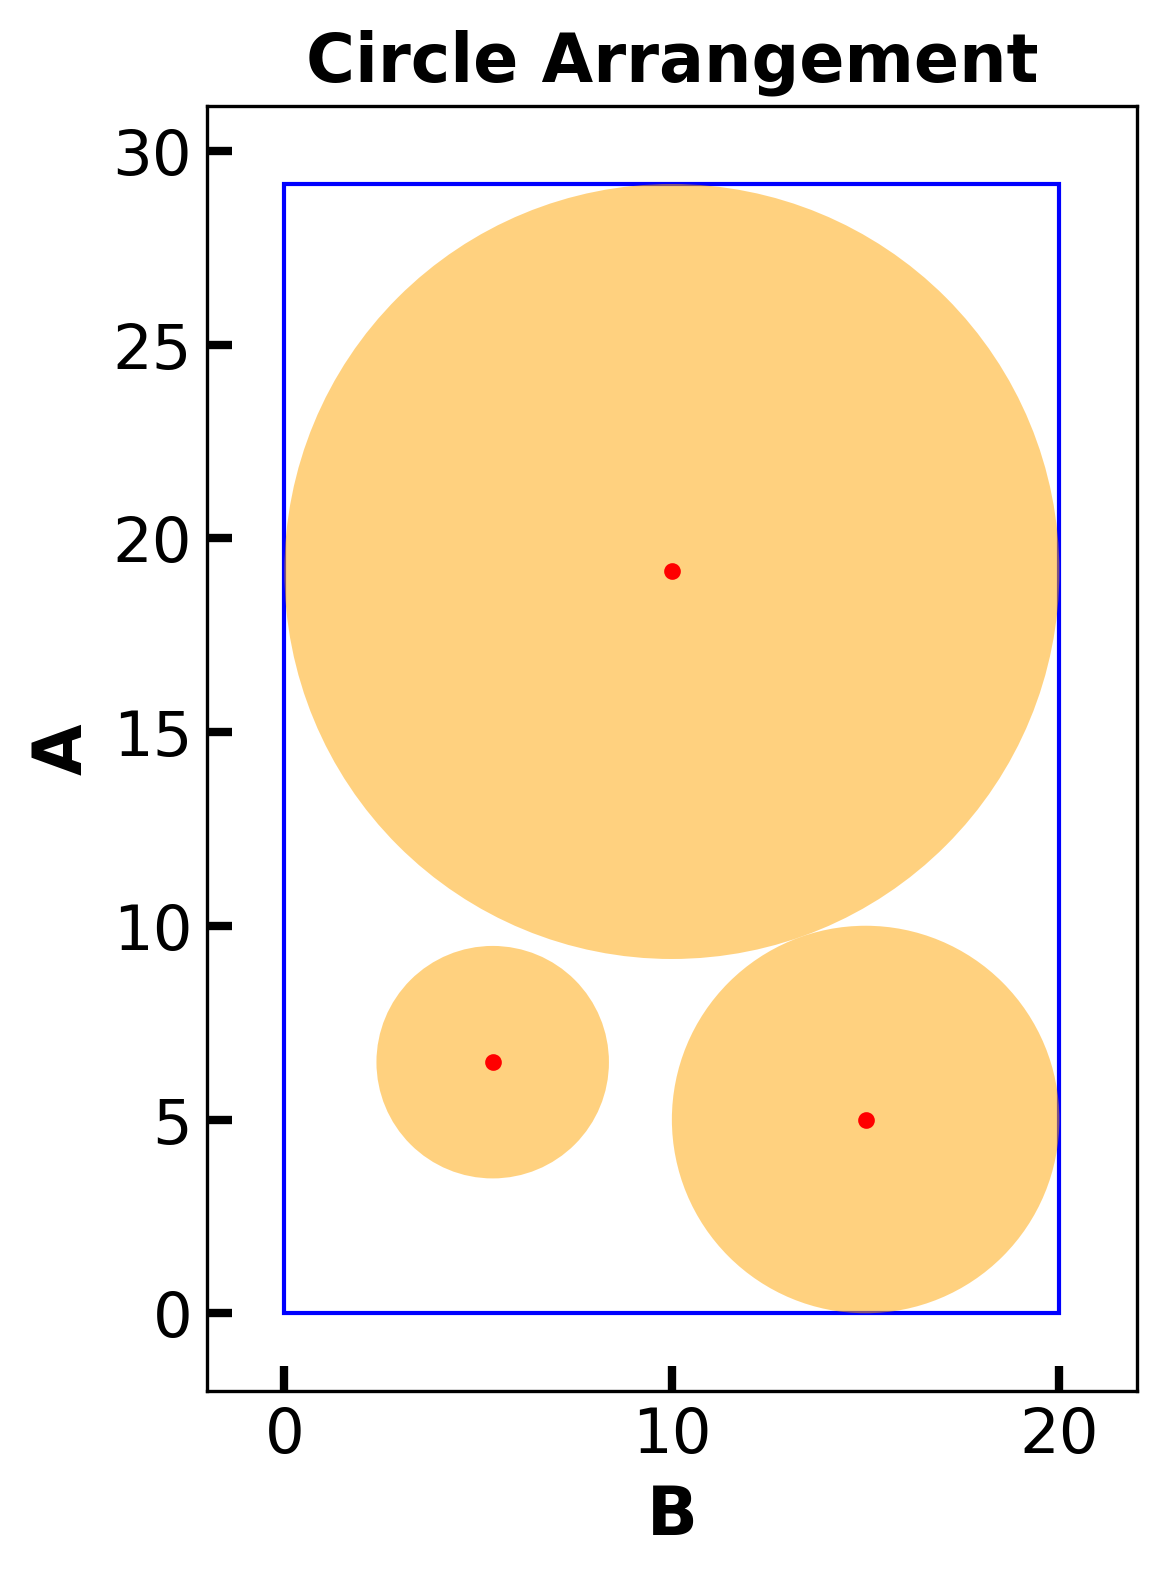

In [ ]:
# Print variable values
print("Name\tValue")
for c in model.component_data_objects(pyo.Var):
    print(c.name,"\t", pyo.value(c))

# Plot solution
plot_circles(model)

In [ ]:
# Print constraints
for c in model.component_data_objects(pyo.Constraint):
    print(c.name,"\t", pyo.value(c.lower),"\t", pyo.value(c.body),"\t", pyo.value(c.upper))

left_x_con[A] 	 10.0 	 10.0 	 None
left_x_con[B] 	 5.0 	 14.999999850009898 	 None
left_x_con[C] 	 3.0 	 5.3759828526460005 	 None
left_y_con[A] 	 10.0 	 19.142135511875615 	 None
left_y_con[B] 	 5.0 	 5.0 	 None
left_y_con[C] 	 3.0 	 6.479397184813547 	 None
right_x_con[A] 	 None 	 0.0 	 0.0
right_x_con[B] 	 None 	 -1.4999010211624864e-07 	 0.0
right_x_con[C] 	 None 	 -11.624017147354 	 0.0
right_y_con[A] 	 None 	 9.999500250046367e-08 	 0.0
right_y_con[B] 	 None 	 -19.142135411880613 	 0.0
right_y_con[C] 	 None 	 -19.662738227067067 	 0.0
no_overlap_con[A,B] 	 225.0 	 224.99999533635236 	 None
no_overlap_con[A,C] 	 169.0 	 181.7264765186705 	 None
no_overlap_con[B,C] 	 64.0 	 94.81031919598345 	 None


### BARON Solver (via NEOS Server)

BARON is a global optimization solver that uses a spatial branch-and-bound algorithm to solve Mixed-Integer Nonlinear Programs. Pyomo does not have direct interation with the BARON solver, therefore, you can use a GAMS file writer and upload the .gms model to the NEOS BARON server.

**Step 1**: Reinitialize your model

**Step 2**: Import the ProblemWriter_gams class, which is a Pyomo plugin for writing optimization models to a file in GAMS (General Algebraic Modeling System) format. More information here: https://pyomo.readthedocs.io/en/6.8.0/library_reference/solvers/gams.html#pyomo.repn.plugins.gams_writer.ProblemWriter_gams


**Step 3**: Write and export the model to a .gms file name of your choice.

**Step 4**: Open https://neos-server.org/neos/solvers/go:BARON/GAMS.html and fill-out the web submission form. Input your email address and wait for your project to finish.

**Step 5**: Upload the 'solve.log' file to the session storage and use the script below to read the file and print the results.

In [ ]:
# Be sure to Re-initialize before writing writting GAMS file
initialize_circle_model(model)

In [ ]:
# Import the GAMS writer from Pyomo's representation plugins
from pyomo.repn.plugins.gams_writer import ProblemWriter_gams

# Write the Pyomo model to a file in GAMS format
# - 'circles_1.gms' is the output file name
# - io_options specifies that symbolic names (instead of numerical labels) should be used
model.write('circles_1.gms', io_options={'symbolic_solver_labels': True})


('circles_1.gms', 138848276195040)

In [ ]:
# Specify the file path
# file_path = "/content/solve.log"  # Adjust this path if the file location differs

# Open and read the file
# with open(file_path, 'r') as file:
#    content = file.read()

# Print the file content
# print(content)


### Reinitialize

In [ ]:
def initialize_circle_model(model, a_init=25, b_init=50):
    ''' Initialize the x and y coordinates with specific positions

    Arguments:
        a_init: initial value for a (default=100)
        b_init: initial value for b (default=100)

    Returns:
        Nothing. Updates the model in-place.
    '''
    # Set box dimensions
    model.a = a_init
    model.b = b_init

    # Place circles as described
    circle_positions = {
        'A': (10, 13),  # Largest circle on the left
        'B': (25, 13),      # Middle circle in the center
        'C': (33, 13)  # Smallest circle on the right
    }

    for i in model.CIRCLES:
        model.x[i] = circle_positions[i][0]
        model.y[i] = circle_positions[i][1]


In [ ]:
# Create model
model = create_circle_model(circle_data)
#model.pprint()

In [ ]:
# Initialize model
initialize_circle_model(model)
#model.pprint()

Name	Value
a 	 25
b 	 50
x[A] 	 10
x[B] 	 25
x[C] 	 33
y[A] 	 13
y[B] 	 13
y[C] 	 13


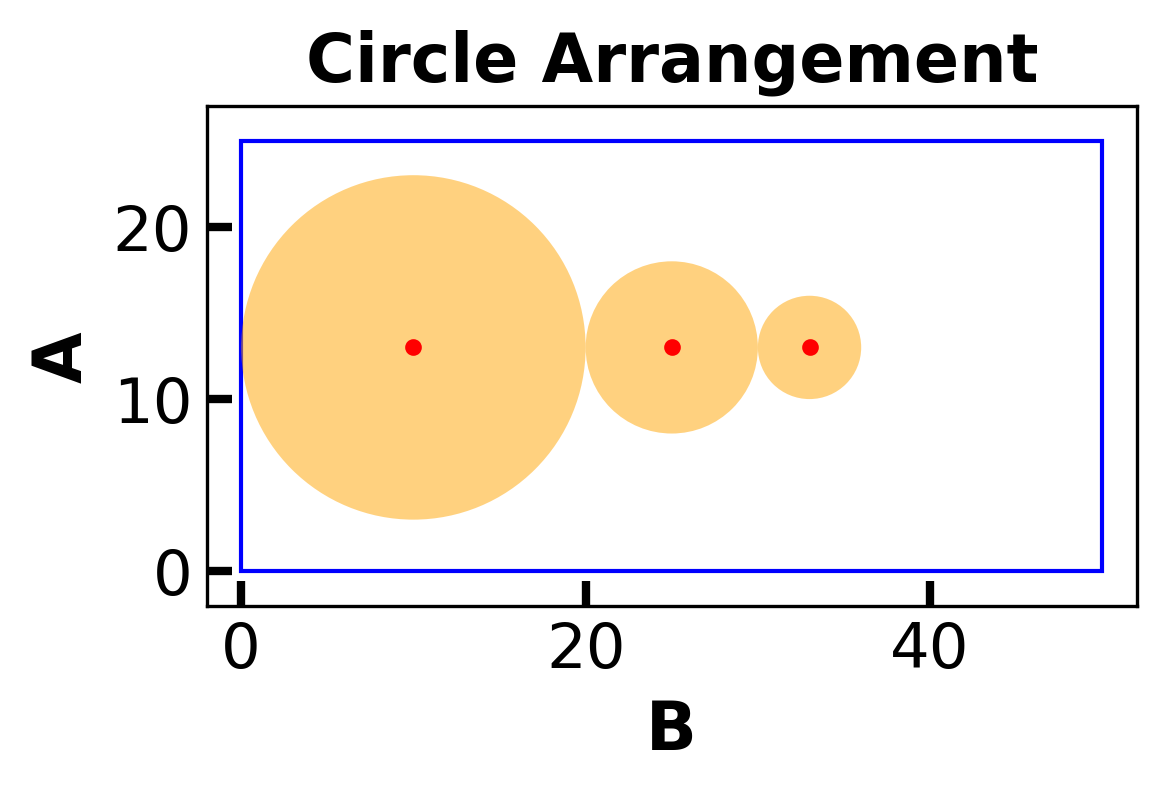

In [ ]:
# Print variable values
print("Name\tValue")
for c in model.component_data_objects(pyo.Var):
    print(c.name,"\t", pyo.value(c))

# Plot solution
plot_circles(model)

### Solve with IPOPT

In [ ]:
solver = pyo.SolverFactory('ipopt')

# Solve the model
results = solver.solve(model, tee = True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Name	Value
a 	 19.99999980319163
b 	 34.88810209495348
x[A] 	 9.999999901252709
x[B] 	 24.14213546828912
x[C] 	 31.888102123700754
y[A] 	 9.999999901252576
y[B] 	 14.99999984015795
y[C] 	 16.999999828328722
Perimeter:  109.77620379629022


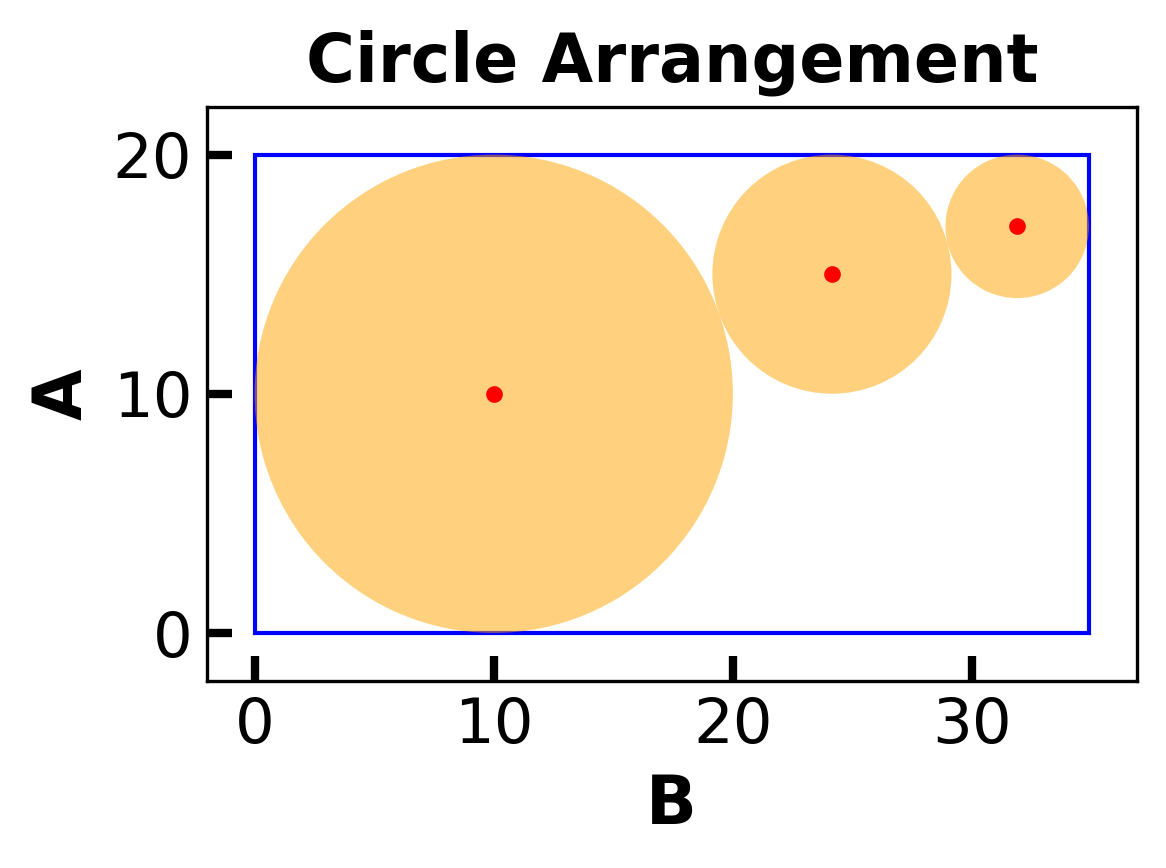

In [ ]:
# Print variable values
print("Name\tValue")
for c in model.component_data_objects(pyo.Var):
    print(c.name,"\t", pyo.value(c))

# Plot solution
print("Perimeter: ", 2*pyo.value(model.a) + 2*pyo.value(model.b))
plot_circles(model)


### Solve with Couenne

In [ ]:
#Specify the solver
solver = pyo.SolverFactory('couenne')

# Solve the model
results = solver.solve(model, tee = True)
model.display()

Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne: 
ANALYSIS TEST: NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 98.28427       30 0.014939
Couenne: new cutoff value 9.8284270824e+01 (0.026413 seconds)
Loaded instance "/tmp/tmpj1dw3wok.pyomo.nl"
Constraints:           15
Variables:              8 (0 integer)
Auxiliaries:           16 (0 integer)

Coin0506I Presolve 40 (0) rows, 21 (-3) columns and 87 (-3) elements
Clp0006I 0  Obj 80 Primal inf 980.53922 (21)
Clp0006I 17  Obj 80
Clp0000I Optimal - objective value 80
Clp0032I Optimal objective 80 - 17 iterations time 0.002, Presolve 0.00
Clp0000I Optimal - objective value 80
Cbc0012I Integer solution of 98.284271 found by Couenne Rounding NLP after 0 iterations and 0 nodes (0.00 seconds)
NLP Heuristic: NLP0014I             2      

Name	Value
a 	 20.0
b 	 29.142085401919054
x[A] 	 19.142085401919054
x[B] 	 5.0
x[C] 	 6.379299717016571
y[A] 	 10.0
y[B] 	 15.0
y[C] 	 7.065784152449444
Perimeter:  98.28417080383811


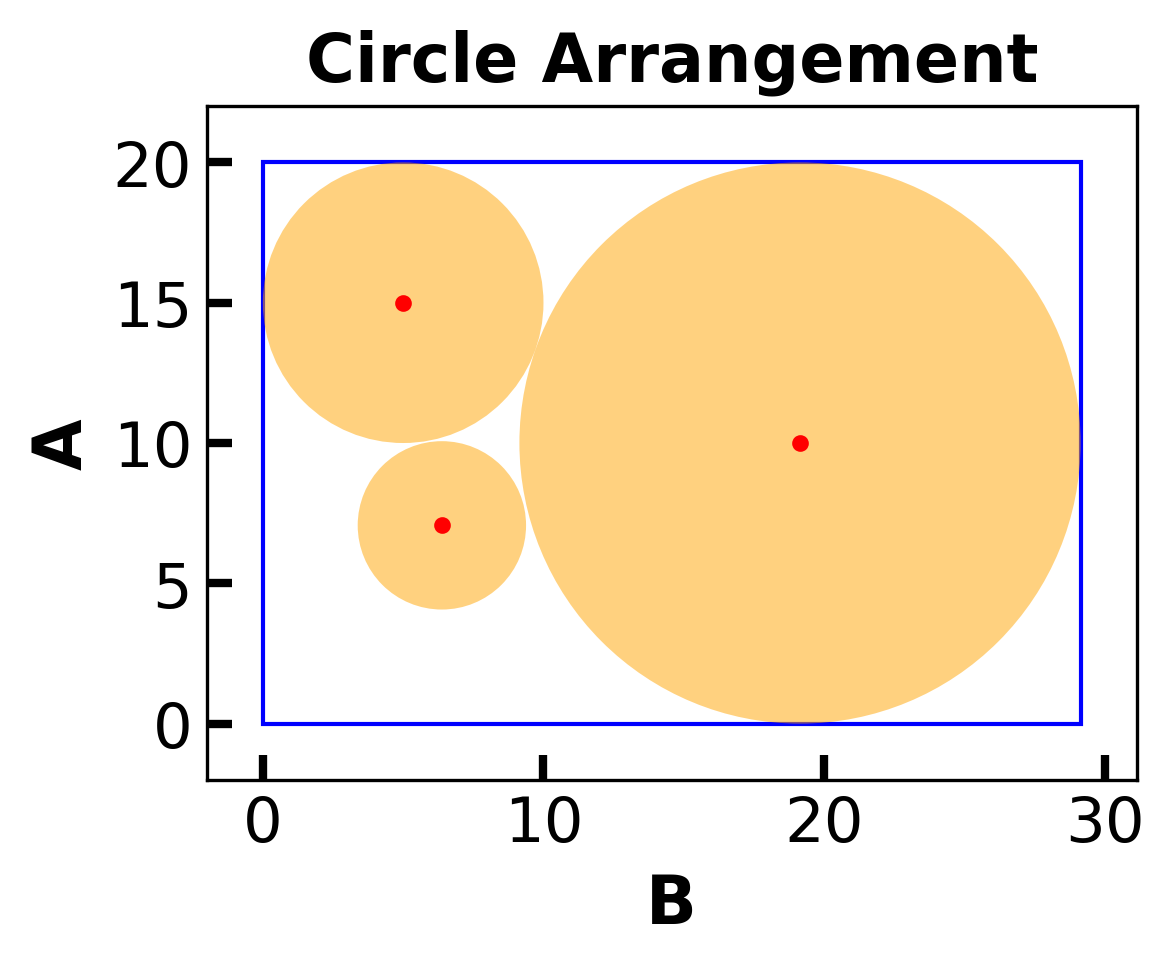

In [ ]:
# Print variable values
print("Name\tValue")
for c in model.component_data_objects(pyo.Var):
    print(c.name,"\t", pyo.value(c))

# Plot solution
print("Perimeter: ", 2*pyo.value(model.a) + 2*pyo.value(model.b))
plot_circles(model)

### Solve with Baron

In [ ]:
# Initialize Before Accessing GAMS Writer
initialize_circle_model(model)

In [ ]:
# Import the GAMS writer from Pyomo's representation plugins
from pyomo.repn.plugins.gams_writer import ProblemWriter_gams

# Write the Pyomo model to a file in GAMS format
# - 'circles_2.gms' is the output file name
# - io_options specifies that symbolic names (instead of numerical labels) should be used
model.write('circles_2.gms', io_options={'symbolic_solver_labels': True})

('circles_2.gms', 138848276106736)

```gams
$offlisting
$offdigit

EQUATIONS
	left_x_con_A__lo
	left_x_con_B__lo
	left_x_con_C__lo
	left_y_con_A__lo
	left_y_con_B__lo
	left_y_con_C__lo
	right_x_con_A__hi
	right_x_con_B__hi
	right_x_con_C__hi
	right_y_con_A__hi
	right_y_con_B__hi
	right_y_con_C__hi
	no_overlap_con_A_B__lo
	no_overlap_con_A_C__lo
	no_overlap_con_B_C__lo
	obj;

POSITIVE VARIABLES
	x_A_
	x_B_
	x_C_
	y_A_
	y_B_
	y_C_
	b
	a;

VARIABLES
	GAMS_OBJECTIVE
	;


left_x_con_A__lo.. 10 =l= x_A_ ;
left_x_con_B__lo.. 5 =l= x_B_ ;
left_x_con_C__lo.. 3 =l= x_C_ ;
left_y_con_A__lo.. 10 =l= y_A_ ;
left_y_con_B__lo.. 5 =l= y_B_ ;
left_y_con_C__lo.. 3 =l= y_C_ ;
right_x_con_A__hi.. x_A_ - (b + (-10)) =l= 0 ;
right_x_con_B__hi.. x_B_ - (b + (-5)) =l= 0 ;
right_x_con_C__hi.. x_C_ - (b + (-3)) =l= 0 ;
right_y_con_A__hi.. y_A_ - (a + (-10)) =l= 0 ;
right_y_con_B__hi.. y_B_ - (a + (-5)) =l= 0 ;
right_y_con_C__hi.. y_C_ - (a + (-3)) =l= 0 ;
no_overlap_con_A_B__lo.. 225 =l= power((x_A_ - x_B_), 2) + power((y_A_ - y_B_), 2) ;
no_overlap_con_A_C__lo.. 169 =l= power((x_A_ - x_C_), 2) + power((y_A_ - y_C_), 2) ;
no_overlap_con_B_C__lo.. 64 =l= power((x_B_ - x_C_), 2) + power((y_B_ - y_C_), 2) ;
obj.. GAMS_OBJECTIVE =e= 2*(a + b) ;

x_A_.l = 10;
x_B_.l = 25;
x_C_.l = 33;
y_A_.l = 13;
y_B_.l = 13;
y_C_.l = 13;
b.l = 50;
a.l = 25;

MODEL GAMS_MODEL /all/ ;
option solprint=off;
option limrow=0;
option limcol=0;
option solvelink=5;
SOLVE GAMS_MODEL USING nlp minimizing GAMS_OBJECTIVE;

Scalars MODELSTAT 'model status', SOLVESTAT 'solve status';
MODELSTAT = GAMS_MODEL.modelstat;
SOLVESTAT = GAMS_MODEL.solvestat;

Scalar OBJEST 'best objective', OBJVAL 'objective value';
OBJEST = GAMS_MODEL.objest;
OBJVAL = GAMS_MODEL.objval;

Scalar NUMVAR 'number of variables';
NUMVAR = GAMS_MODEL.numvar

Scalar NUMEQU 'number of equations';
NUMEQU = GAMS_MODEL.numequ

Scalar NUMDVAR 'number of discrete variables';
NUMDVAR = GAMS_MODEL.numdvar

Scalar NUMNZ 'number of nonzeros';
NUMNZ = GAMS_MODEL.numnz

Scalar ETSOLVE 'time to execute solve statement';
ETSOLVE = GAMS_MODEL.etsolve


```


In [ ]:
# Specify the file path
#file_path = "/content/BARON_Output1.log"  # Adjust this path if the file location differs

# Open and read the file
#with open(file_path, 'r') as file:
#    content = file.read()

# Print the file content
#print(content)

```log
--- Job MODEL.gms Start 12/10/24 16:25:29 47.6.0 c2de9d6d LEX-LEG x86 64bit/Linux
--- Applying:
--- GAMS Parameters defined
    Input /var/lib/condor/execute/dir_1446120/gamsexec/MODEL.gms
    Output /var/lib/condor/execute/dir_1446120/gamsexec/solve.lst
    PageWidth 79
    PageSize 0
    ScrDir /var/lib/condor/execute/dir_1446120/neos-1446125/
    SysDir /opt/gams/47.6.0/
    CurDir /var/lib/condor/execute/dir_1446120/gamsexec/
    LogOption 4
    LogFile /var/lib/condor/execute/dir_1446120/gamsexec/solve.log
    AppendOut 1
    AppendLog 0
    Suppress 0
    CErr 10
    LimRow 0
    LimCol 0
    IDE 1
    GDX /var/lib/condor/execute/dir_1446120/gamsexec/out.gdx
    ExecMode 3
    gdxCompress 1
    Solver baron
Licensee: NEOS Server License                            G241014+0003Ac-GEN
          Wisconsin Institutes for Discovery                        DCE1890
          /opt/gams/47.6.0/gamslice.txt
          node:90046401                                                    
          Evaluation license: Not for commercial or production use
          The evaluation period of the license will expire on Dec 08, 2025
Processor information: 2 socket(s), 32 core(s), and 64 thread(s) available
GAMS 47.6.0   Copyright (C) 1987-2024 GAMS Development. All rights reserved
--- Starting compilation
--- MODEL.gms(96) 2 Mb[FIL:"/var/lib/condor/execute/dir_1446120/gamsexec/MODEL.gms",96,0]
--- Starting execution: elapsed 0:00:00.015[LST:10]
--- MODEL.gms(71) 3 Mb[FIL:"/var/lib/condor/execute/dir_1446120/gamsexec/MODEL.gms",71,0]
--- Generating NLP model GAMS_MODEL[LST:10]
--- MODEL.gms(72) 5 Mb[FIL:"/var/lib/condor/execute/dir_1446120/gamsexec/MODEL.gms",72,0]
--- Reset Solvelink = 2
---   16 rows  9 columns  33 non-zeroes
---   30 nl-code  12 nl-non-zeroes
--- Range statistics (absolute non-zero finite values)
--- RHS       [min, max] : [ 3.000E+00, 2.250E+02] - Zero values observed as well
--- Bound     [min, max] : [        NA,        NA] - Zero values observed as well
--- Matrix    [min, max] : [ 1.000E+00, 4.600E+01] - Zero values observed as well
--- MODEL.gms(72) 3 Mb[FIL:"/var/lib/condor/execute/dir_1446120/gamsexec/MODEL.gms",72,0]
--- Executing BARON (Solvelink=2): elapsed 0:00:00.017[LST:23]

GAMS/BARON       47.6.0 c2de9d6d Sep 12, 2024          LEG x86 64bit/Linux    

===========================================================================
 BARON version 24.5.8. Built: LNX-64 Wed May 8 10:06:40 EDT 2024
 Running on machine prod-exec-7.neos-server.org

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron

 If you publish work using this software, please cite publications from
 https://minlp.com/baron-publications, such as:

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
===========================================================================
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC, ILOG CPLEX                             
 For NLP: MINOS, SNOPT, External NLP, IPOPT, FILTERSQP
===========================================================================
 Starting solution is feasible with a value of   150.000          
 Doing local search
 Preprocessing found feasible solution with value 98.2843
 Solving bounding LP
 Starting multi-start local search
 Done with local search
===========================================================================
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
          1             1             0.04      80.0000          98.2843                 
         11             0             0.08      98.2843          98.2843                 

                         *** Normal completion ***            

 Wall clock time:                     0.09
 Total CPU time used:                 0.08

 Total no. of BaR iterations:      11
 Best solution found at node:      -1
 Max. no. of nodes in memory:       3

 All done
===========================================================================

Solution      = 98.2842712474619  best solution found during preprocessing
Best possible = 98.2842712474619
Absolute gap  = 0  optca = 1E-9
Relative gap  = 0  optcr = 0.0001

--- Reading solution for model GAMS_MODEL[LST:35]
***
*** Solver did not provide marginals for model GAMS_MODEL
***
--- Executing after solve: elapsed 0:00:00.134[LST:89]
--- MODEL.gms(95) 3 Mb[FIL:"/var/lib/condor/execute/dir_1446120/gamsexec/MODEL.gms",95,0]
--- GDX File /var/lib/condor/execute/dir_1446120/gamsexec/out.gdx[FIL:"/var/lib/condor/execute/dir_1446120/gamsexec/out.gdx",0,0]
*** Status: Normal completion[LST:105]
--- Job MODEL.gms Stop 12/10/24 16:25:29 elapsed 0:00:00.134

```


## Takeaway Messages
* A global solution for a nonconvex, nonlinear program can often be found given the problem meets certain criteria.
* Solvers like Couenne or BARON have the capability to find the global optima of certain NLPs.
* Methods like Spatial branch and bound can guarantee the optimiality of solutions found for non linear programs with poor initialization given the complexity of the GO problem falls within certain assumptions.
*Spatial branch and bound methods guarantee convergence but not in a finite number of steps.
* Spatial Branch and Bound Methods partition the feasible region into subregions and enumerate each subregions optimal solution. These solutions converge to a globally optimal solution.

## References

Biegler, L. T. (2010). Nonlinear programming: concepts, algorithms, and applications to chemical processes. Society for Industrial and Applied Mathematics.

Locatelli, M., & Schoen, F. (Eds.). (2013). Global optimization: theory, algorithms, and applications. Society for Industrial and Applied Mathematics.

NEOS Server. (n.d.). BARON solver for GAMS. NEOS Server. Retrieved December 9, 2024, from https://neos-server.org/neos/solvers/go:BARON/GAMS.html

Pyomo Documentation. (n.d.). ProblemWriter_gams — Pyomo documentation (version 6.8.0). Retrieved December 9, 2024, from https://pyomo.readthedocs.io/en/6.8.0/library_reference/solvers/gams.html#pyomo.repn.plugins.gams_writer.ProblemWriter_gams

https://optimization.cbe.cornell.edu/index.php?title=Spatial_branch_and_bound_method